# Разведочный анализ данных (EDA): Прогнозирование самовозгорания угля при открытом хранении

**Цель хакатона:** Разработать WEB-приложение для прогнозирования даты самовозгорания угля в штабелях при открытом хранении.

**Требования к решению:**
- Прогноз должен формироваться на горизонте не менее 3 дней
- Точность: не менее 70% прогнозов в пределах ±2 дня от реальной даты возгорания

**Данный notebook содержит первичный анализ данных для понимания:**
1. Структуры и качества данных
2. Паттернов изменения температуры в штабелях
3. Влияния погодных условий
4. Горизонта прогнозирования (за сколько дней до возгорания начинается рост температуры)

---

## 1. Импорт библиотек и настройка окружения

Начнем с импорта необходимых библиотек для анализа данных и визуализации. Мы будем использовать стандартный набор инструментов для работы с временными рядами и табличными данными.

In [ ]:
# Основные библиотеки для работы с данными
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Библиотеки для статистического анализа
from scipy import stats
from scipy.stats import pearsonr, spearmanr

# Настройка отображения графиков
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Настройка pandas для удобного отображения
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

print("✓ Все библиотеки успешно импортированы")
print(f"Версия pandas: {pd.__version__}")
print(f"Версия numpy: {np.__version__}")

✓ Все библиотеки успешно импортированы
Версия pandas: 2.2.2
Версия numpy: 2.0.2


## 2. Загрузка данных

Согласно описанию задачи, у нас есть четыре основных источника данных:

1. **supplies.csv** - Данные о выгрузке на склад и отгрузке со склада (формирование и разборка штабелей)
2. **fires.csv** - Информация о фактических случаях самовозгорания (перегревах)
3. **temperature.csv** - Показатели температуры в штабелях (регулярные измерения)
4. **weather_data_YYYY.csv** - Метеорологические данные (температура воздуха, влажность, ветер и т.д.)

Давайте загрузим эти данные и изучим их структуру.

In [ ]:
# Определяем путь к данным
# Для Google Colab: загрузите файлы в папку 'data' или измените путь
DATA_PATH = 'data/'

# Загрузка данных о поставках и формировании штабелей
print("Загружаем данные о поставках угля...")
supplies_df = pd.read_csv(f'{DATA_PATH}supplies.csv')
print(f"✓ Загружено {len(supplies_df)} записей о поставках")

# Загрузка данных о возгораниях/перегревах
print("\nЗагружаем данные о возгораниях...")
fires_df = pd.read_csv(f'{DATA_PATH}fires.csv')
print(f"✓ Загружено {len(fires_df)} записей о возгораниях")

# Загрузка температурных данных
print("\nЗагружаем температурные измерения штабелей...")
temperature_df = pd.read_csv(f'{DATA_PATH}temperature.csv')
print(f"✓ Загружено {len(temperature_df)} температурных измерений")

# Загрузка погодных данных за все годы
print("\nЗагружаем погодные данные...")
weather_years = [2015, 2016, 2017, 2018, 2019, 2020, 2021]
weather_dfs = []

for year in weather_years:
    try:
        df = pd.read_csv(f'{DATA_PATH}weather_data_{year}.csv')
        weather_dfs.append(df)
        print(f"  ✓ {year}: {len(df)} записей")
    except FileNotFoundError:
        print(f"  ✗ Файл для {year} года не найден")

# Объединяем все погодные данные в один DataFrame
weather_df = pd.concat(weather_dfs, ignore_index=True)
print(f"\n✓ Всего погодных записей: {len(weather_df)}")

print("\n" + "="*60)
print("ВСЕ ДАННЫЕ УСПЕШНО ЗАГРУЖЕНЫ")
print("="*60)

Загружаем данные о поставках угля...
✓ Загружено 6323 записей о поставках

Загружаем данные о возгораниях...
✓ Загружено 486 записей о возгораниях

Загружаем температурные измерения штабелей...
✓ Загружено 4106 температурных измерений

Загружаем погодные данные...
  ✓ 2015: 8760 записей
  ✓ 2016: 8760 записей
  ✓ 2017: 8760 записей
  ✓ 2018: 8784 записей
  ✓ 2019: 8760 записей
  ✓ 2020: 8760 записей
  ✓ 2021: 8760 записей

✓ Всего погодных записей: 61344

ВСЕ ДАННЫЕ УСПЕШНО ЗАГРУЖЕНЫ


## 3. Первичный осмотр данных

### 3.1 Данные о температуре штабелей

Это наш ключевой источник информации для прогнозирования. Температурные измерения проводятся регулярно для мониторинга состояния штабелей.

In [ ]:
print("=" * 60)
print("СТРУКТУРА ТЕМПЕРАТУРНЫХ ДАННЫХ")
print("=" * 60)

print("\n1. Первые строки датасета:")
display(temperature_df.head(10))

print("\n2. Информация о столбцах:")
print(temperature_df.info())

print("\n3. Описательная статистика:")
display(temperature_df.describe())

print("\n4. Проверка на пропущенные значения:")
missing_temp = temperature_df.isnull().sum()
missing_temp_pct = (missing_temp / len(temperature_df)) * 100
missing_summary = pd.DataFrame({
    'Пропусков': missing_temp,
    'Процент': missing_temp_pct
})
display(missing_summary[missing_summary['Пропусков'] > 0])

print("\n5. Уникальные значения ключевых полей:")
print(f"   - Уникальных складов: {temperature_df['Склад'].nunique()}")
print(f"   - Уникальных штабелей: {temperature_df['Штабель'].nunique()}")
print(f"   - Уникальных марок угля: {temperature_df['Марка'].nunique()}")
print(f"   - Марки угля: {temperature_df['Марка'].unique()}")

СТРУКТУРА ТЕМПЕРАТУРНЫХ ДАННЫХ

1. Первые строки датасета:


,Склад,Штабель,Марка,Максимальная температура,Пикет,Дата акта,Смена
0,3,43,A1,36.20,3045-3075,2020-08-05,219.00
1,4,39,A1,109.40,4025-4047,2020-08-05,219.00
2,4,23,A1,38.60,4048-4052,2020-08-05,219.00
3,4,46,A1,37.30,4057-4077,2020-08-05,219.00
4,4,12,A1,36.40,4091-4112,2020-08-05,219.00
5,6,45,A1,37.00,6017-6023,2020-08-05,219.00
6,6,1,A1,45.60,6024-6034,2020-08-05,219.00
7,6,10,A1,39.30,6045-6053,2020-08-05,219.00
8,6,5,A1,36.50,6057-6062,2020-08-05,219.00
9,6,1,A1,190.00,6063-6081,2020-08-05,219.00



2. Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4106 entries, 0 to 4105
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Склад                     4106 non-null   int64  
 1   Штабель                   4106 non-null   int64  
 2   Марка                     4106 non-null   object 
 3   Максимальная температура  4106 non-null   float64
 4   Пикет                     3647 non-null   object 
 5   Дата акта                 4106 non-null   object 
 6   Смена                     3949 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 224.7+ KB
None

3. Описательная статистика:


,Склад,Штабель,Максимальная температура,Смена
count,4106.00,4106.00,4106.00,3949.00
mean,4.28,22.91,44.56,602.98
std,1.19,17.03,49.55,349.49
min,3.00,0.00,0.00,219.00
25%,3.00,5.00,27.10,219.00
50%,4.00,23.00,33.90,921.00
75%,6.00,39.00,38.90,921.00
max,6.00,62.00,679.00,921.00



4. Проверка на пропущенные значения:


,Пропусков,Процент
Пикет,459,11.18
Смена,157,3.82



5. Уникальные значения ключевых полей:
   - Уникальных складов: 3
   - Уникальных штабелей: 52
   - Уникальных марок угля: 23
   - Марки угля: ['A1' 'A1-СКГ' 'A1-МТ-ШУБ' 'A1-КРУ' 'A1-СА-ШУБ' 'A1-СУЭК' 'A1-КТК'
 'A1-САШУБ' 'A1-МТШУБ' 'FL-' 'A1-КГК' 'A1-СА-' 'A1-МТ-' 'A1-СУЭК-'
 'A1-СУЭК-КАМ' 'A1-СТР-' 'A1-СТР' 'A1-ГЕН-МЕР' 'A1-ГЕН-' 'NAN' 'A1-ЕР' 'А'
 'Я']


### 3.2 Подготовка температурных данных для анализа

Необходимо преобразовать дату в формат datetime для корректной работы с временными рядами.

In [ ]:
# Преобразование даты в datetime формат
temperature_df['Дата акта'] = pd.to_datetime(temperature_df['Дата акта'])

# Сортировка по дате для корректного анализа временных рядов
temperature_df = temperature_df.sort_values('Дата акта').reset_index(drop=True)

# Создаем идентификатор штабеля (склад + номер штабеля)
temperature_df['ID_штабеля'] = temperature_df['Склад'].astype(str) + '_' + temperature_df['Штабель'].astype(str)

print("Временной диапазон температурных данных:")
print(f"  От: {temperature_df['Дата акта'].min()}")
print(f"  До: {temperature_df['Дата акта'].max()}")
print(f"  Период: {(temperature_df['Дата акта'].max() - temperature_df['Дата акта'].min()).days} дней")

# Статистика по температурам
print("\nСтатистика температур:")
print(f"  Минимальная: {temperature_df['Максимальная температура'].min():.1f}°C")
print(f"  Средняя: {temperature_df['Максимальная температура'].mean():.1f}°C")
print(f"  Медиана: {temperature_df['Максимальная температура'].median():.1f}°C")
print(f"  Максимальная: {temperature_df['Максимальная температура'].max():.1f}°C")
print(f"  Стандартное отклонение: {temperature_df['Максимальная температура'].std():.1f}°C")

# Выявление аномально высоких температур (потенциальные предвестники возгорания)
high_temp_threshold = 70  # °C - критический порог
critical_temps = temperature_df[temperature_df['Максимальная температура'] > high_temp_threshold]
print(f"\n⚠ Обнаружено {len(critical_temps)} измерений с температурой выше {high_temp_threshold}°C")
print(f"   Это составляет {len(critical_temps)/len(temperature_df)*100:.2f}% от всех измерений")

Временной диапазон температурных данных:
  От: 2019-11-23 00:00:00
  До: 2020-09-30 00:00:00
  Период: 312 дней

Статистика температур:
  Минимальная: 0.0°C
  Средняя: 44.6°C
  Медиана: 33.9°C
  Максимальная: 679.0°C
  Стандартное отклонение: 49.6°C

⚠ Обнаружено 404 измерений с температурой выше 70°C
   Это составляет 9.84% от всех измерений


### 3.3 Данные о возгораниях (fires.csv)

Это референсные данные о фактических случаях перегрева или экстренной отгрузки угля из-за риска самовозгорания.

In [ ]:
print("=" * 60)
print("СТРУКТУРА ДАННЫХ О ВОЗГОРАНИЯХ")
print("=" * 60)

print("\n1. Первые строки:")
display(fires_df.head(10))

print("\n2. Информация о столбцах:")
print(fires_df.info())

# Преобразуем даты
date_columns = ['Дата составления', 'Дата начала', 'Дата оконч.', 'Нач.форм.штабеля']
for col in date_columns:
    fires_df[col] = pd.to_datetime(fires_df[col])

# Создаем ID штабеля для связи с температурными данными
fires_df['ID_штабеля'] = fires_df['Склад'].astype(str) + '_' + fires_df['Штабель'].astype(str)

# Вычисляем время хранения до инцидента
fires_df['Дней_до_инцидента'] = (fires_df['Дата составления'] - fires_df['Нач.форм.штабеля']).dt.days

print("\n3. Статистика по возгораниям:")
print(f"   Общее количество инцидентов: {len(fires_df)}")
print(f"   Уникальных штабелей с инцидентами: {fires_df['ID_штабеля'].nunique()}")
print(f"   Период инцидентов: с {fires_df['Дата составления'].min()} по {fires_df['Дата составления'].max()}")

print("\n4. Распределение инцидентов по складам:")
display(fires_df['Склад'].value_counts().sort_index())

print("\n5. Время хранения до возгорания:")
print(f"   Минимальное: {fires_df['Дней_до_инцидента'].min()} дней")
print(f"   Среднее: {fires_df['Дней_до_инцидента'].mean():.1f} дней")
print(f"   Медиана: {fires_df['Дней_до_инцидента'].median():.1f} дней")
print(f"   Максимальное: {fires_df['Дней_до_инцидента'].max()} дней")

СТРУКТУРА ДАННЫХ О ВОЗГОРАНИЯХ

1. Первые строки:


,Дата составления,Груз,"Вес по акту, тн",Склад,Дата начала,Дата оконч.,Нач.форм.штабеля,Штабель
0,2019-03-19,A1,255.00,4,2019-03-19 09:00:00,2019-03-19 21:00:00,2018-11-23 00:00:00,6
1,2019-03-24,B2,42.50,3,2019-03-24 09:00:00,2019-03-24 21:00:00,2019-01-03 00:00:00,21
2,2019-03-25,B2,72.25,3,2018-03-24 21:00:00,2019-03-25 09:00:00,2019-01-03 00:00:00,21
3,2019-06-11,A1,127.50,4,2019-06-11 09:00:00,2019-06-11 21:00:00,2019-04-28 23:55:00,15
4,2019-07-07,A1,127.50,4,2019-07-06 21:00:00,2019-07-07 09:00:00,2019-05-19 00:00:00,22
5,2019-07-10,A1,85.00,4,2019-07-10 09:00:00,2019-07-10 21:00:00,2019-05-19 00:00:00,22
6,2019-07-11,A1,85.00,4,2019-07-10 21:00:00,2019-07-11 09:00:00,2019-05-19 00:00:00,22
7,2019-07-12,A1,170.00,4,2019-07-11 21:00:00,2019-07-12 09:00:00,2019-05-19 00:00:00,22
8,2019-07-14,A1,170.00,4,2019-07-14 09:00:00,2019-07-14 21:00:00,2019-05-19 00:00:00,22
9,2019-07-14,A1,357.00,4,2019-07-14 09:00:00,2019-07-14 21:00:00,2019-05-19 00:00:00,22



2. Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486 entries, 0 to 485
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Дата составления  486 non-null    object 
 1   Груз              486 non-null    object 
 2   Вес по акту, тн   486 non-null    float64
 3   Склад             486 non-null    int64  
 4   Дата начала       486 non-null    object 
 5   Дата оконч.       486 non-null    object 
 6   Нач.форм.штабеля  486 non-null    object 
 7   Штабель           486 non-null    int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 30.5+ KB
None

3. Статистика по возгораниям:
   Общее количество инцидентов: 486
   Уникальных штабелей с инцидентами: 26
   Период инцидентов: с 2019-03-19 00:00:00 по 2020-09-30 00:00:00

4. Распределение инцидентов по складам:


,count
Склад,
3,102
4,185
6,199



5. Время хранения до возгорания:
   Минимальное: -4 дней
   Среднее: 94.9 дней
   Медиана: 86.0 дней
   Максимальное: 667 дней


### 3.4 Погодные данные

Погодные условия (температура воздуха, влажность, ветер) могут влиять на скорость окисления угля и риск самовозгорания.

In [ ]:
print("=" * 60)
print("СТРУКТУРА ПОГОДНЫХ ДАННЫХ")
print("=" * 60)

print("\n1. Первые строки:")
display(weather_df.head(10))

print("\n2. Информация о столбцах:")
print(weather_df.info())

print("\n3. Названия всех столбцов:")
print(weather_df.columns.tolist())

print("\n4. Описательная статистика:")
display(weather_df.describe())

# Проверяем наличие даты в данных
date_col = [col for col in weather_df.columns if 'дата' in col.lower() or 'date' in col.lower() or 'время' in col.lower()]
print(f"\n5. Столбцы с датой/временем: {date_col}")

СТРУКТУРА ПОГОДНЫХ ДАННЫХ

1. Первые строки:


,date,t,p,humidity,precipitation,wind_dir,v_avg,v_max,cloudcover,visibility,weather_code
0,2015-01-01 00:00:00,-2.10,1026.60,75,0.00,41,34.20,54.00,98,NaN,3
1,2015-01-01 01:00:00,-2.10,1025.90,73,0.00,40,32.20,52.20,99,NaN,3
2,2015-01-01 02:00:00,-2.20,1026.10,75,0.00,36,32.20,50.40,99,NaN,3
3,2015-01-01 03:00:00,-2.20,1025.80,75,0.00,34,33.20,51.50,97,NaN,3
4,2015-01-01 04:00:00,-2.30,1025.90,76,0.00,33,33.50,52.60,100,NaN,3
5,2015-01-01 05:00:00,-2.50,1025.60,78,0.00,32,34.00,53.60,99,NaN,3
6,2015-01-01 06:00:00,-2.60,1025.70,78,0.00,32,32.70,53.30,99,NaN,3
7,2015-01-01 07:00:00,-2.60,1025.60,78,0.00,32,31.10,51.80,100,NaN,3
8,2015-01-01 08:00:00,-2.70,1025.90,77,0.00,32,29.80,49.30,100,NaN,3
9,2015-01-01 09:00:00,-2.60,1026.00,77,0.00,32,27.20,46.80,99,NaN,3



2. Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61344 entries, 0 to 61343
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           61344 non-null  object 
 1   t              61344 non-null  float64
 2   p              61344 non-null  float64
 3   humidity       61344 non-null  int64  
 4   precipitation  61344 non-null  float64
 5   wind_dir       61344 non-null  int64  
 6   v_avg          61344 non-null  float64
 7   v_max          61344 non-null  float64
 8   cloudcover     61344 non-null  int64  
 9   visibility     0 non-null      float64
 10  weather_code   61344 non-null  int64  
dtypes: float64(6), int64(4), object(1)
memory usage: 5.1+ MB
None

3. Названия всех столбцов:
['date', 't', 'p', 'humidity', 'precipitation', 'wind_dir', 'v_avg', 'v_max', 'cloudcover', 'visibility', 'weather_code']

4. Описательная статистика:


,t,p,humidity,precipitation,wind_dir,v_avg,v_max,cloudcover,visibility,weather_code
count,61344.00,61344.00,61344.00,61344.00,61344.00,61344.00,61344.00,61344.00,0.00,61344.00
mean,13.78,1015.76,76.19,0.05,164.10,20.31,29.76,49.30,NaN,7.16
std,8.15,6.95,12.10,0.35,112.02,9.56,13.37,40.86,NaN,16.77
min,-10.20,990.80,27.00,0.00,1.00,0.00,0.70,0.00,NaN,0.00
25%,7.40,1010.80,68.00,0.00,54.00,13.10,19.80,4.00,NaN,0.00
50%,12.90,1015.20,78.00,0.00,172.00,19.50,28.10,46.00,NaN,1.00
75%,21.50,1020.40,86.00,0.00,258.00,26.60,38.20,96.00,NaN,3.00
max,32.00,1040.30,100.00,27.00,360.00,63.40,100.40,100.00,NaN,75.00



5. Столбцы с датой/временем: ['date']


## 4. Визуализация данных

### 4.1 Распределение температур в штабелях

Понимание распределения температур поможет определить нормальные и аномальные значения.

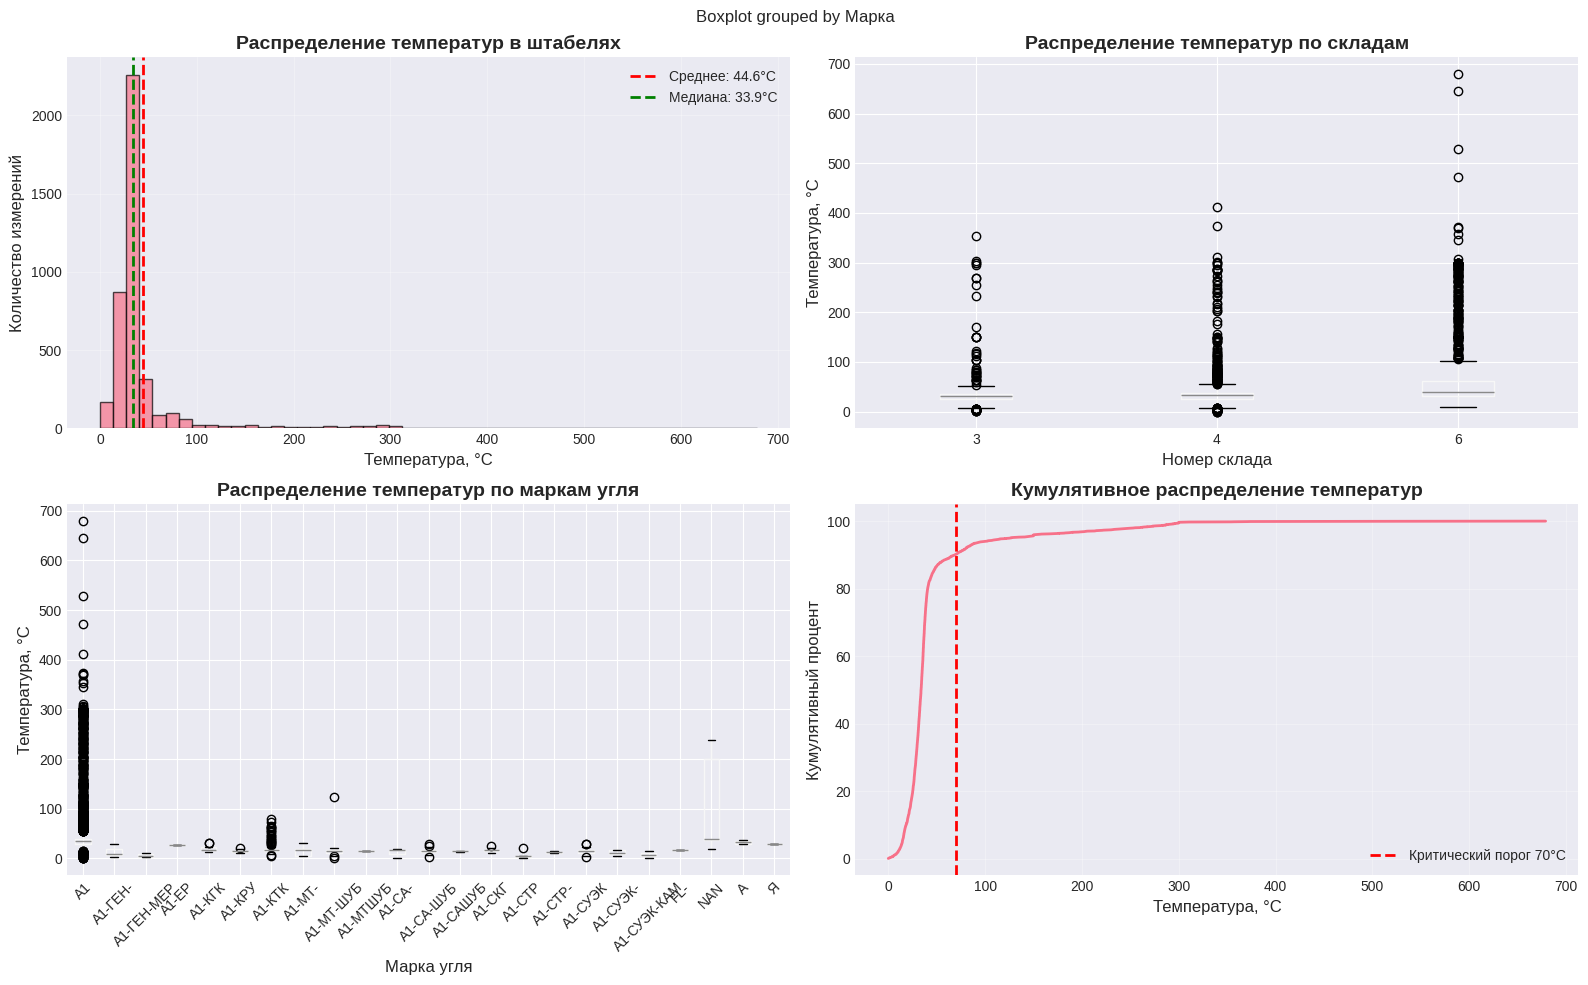


АНАЛИЗ КРИТИЧЕСКИХ ТЕМПЕРАТУР
Температур выше 50°C: 547 (13.32%)
Температур выше 60°C: 464 (11.30%)
Температур выше 70°C: 404 (9.84%)
Температур выше 80°C: 332 (8.09%)
Температур выше 90°C: 270 (6.58%)
Температур выше 100°C: 246 (5.99%)


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Гистограмма распределения температур
axes[0, 0].hist(temperature_df['Максимальная температура'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(temperature_df['Максимальная температура'].mean(),
                   color='red', linestyle='--', linewidth=2, label=f'Среднее: {temperature_df["Максимальная температура"].mean():.1f}°C')
axes[0, 0].axvline(temperature_df['Максимальная температура'].median(),
                   color='green', linestyle='--', linewidth=2, label=f'Медиана: {temperature_df["Максимальная температура"].median():.1f}°C')
axes[0, 0].set_xlabel('Температура, °C', fontsize=12)
axes[0, 0].set_ylabel('Количество измерений', fontsize=12)
axes[0, 0].set_title('Распределение температур в штабелях', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Box plot по складам
temperature_df.boxplot(column='Максимальная температура', by='Склад', ax=axes[0, 1])
axes[0, 1].set_xlabel('Номер склада', fontsize=12)
axes[0, 1].set_ylabel('Температура, °C', fontsize=12)
axes[0, 1].set_title('Распределение температур по складам', fontsize=14, fontweight='bold')
plt.sca(axes[0, 1])
plt.xticks(rotation=0)

# 3. Температуры по маркам угля
temperature_df.boxplot(column='Максимальная температура', by='Марка', ax=axes[1, 0])
axes[1, 0].set_xlabel('Марка угля', fontsize=12)
axes[1, 0].set_ylabel('Температура, °C', fontsize=12)
axes[1, 0].set_title('Распределение температур по маркам угля', fontsize=14, fontweight='bold')
plt.sca(axes[1, 0])
plt.xticks(rotation=45)

# 4. Кумулятивное распределение
sorted_temps = np.sort(temperature_df['Максимальная температура'])
cumulative = np.arange(1, len(sorted_temps) + 1) / len(sorted_temps) * 100
axes[1, 1].plot(sorted_temps, cumulative, linewidth=2)
axes[1, 1].axvline(70, color='red', linestyle='--', linewidth=2, label='Критический порог 70°C')
axes[1, 1].set_xlabel('Температура, °C', fontsize=12)
axes[1, 1].set_ylabel('Кумулятивный процент', fontsize=12)
axes[1, 1].set_title('Кумулятивное распределение температур', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Анализ критических температур
print("\n" + "="*60)
print("АНАЛИЗ КРИТИЧЕСКИХ ТЕМПЕРАТУР")
print("="*60)
for threshold in [50, 60, 70, 80, 90, 100]:
    count = len(temperature_df[temperature_df['Максимальная температура'] > threshold])
    pct = count / len(temperature_df) * 100
    print(f"Температур выше {threshold}°C: {count} ({pct:.2f}%)")

### 4.2 Временные ряды температур

Анализ изменения температуры во времени для понимания динамики процесса окисления.

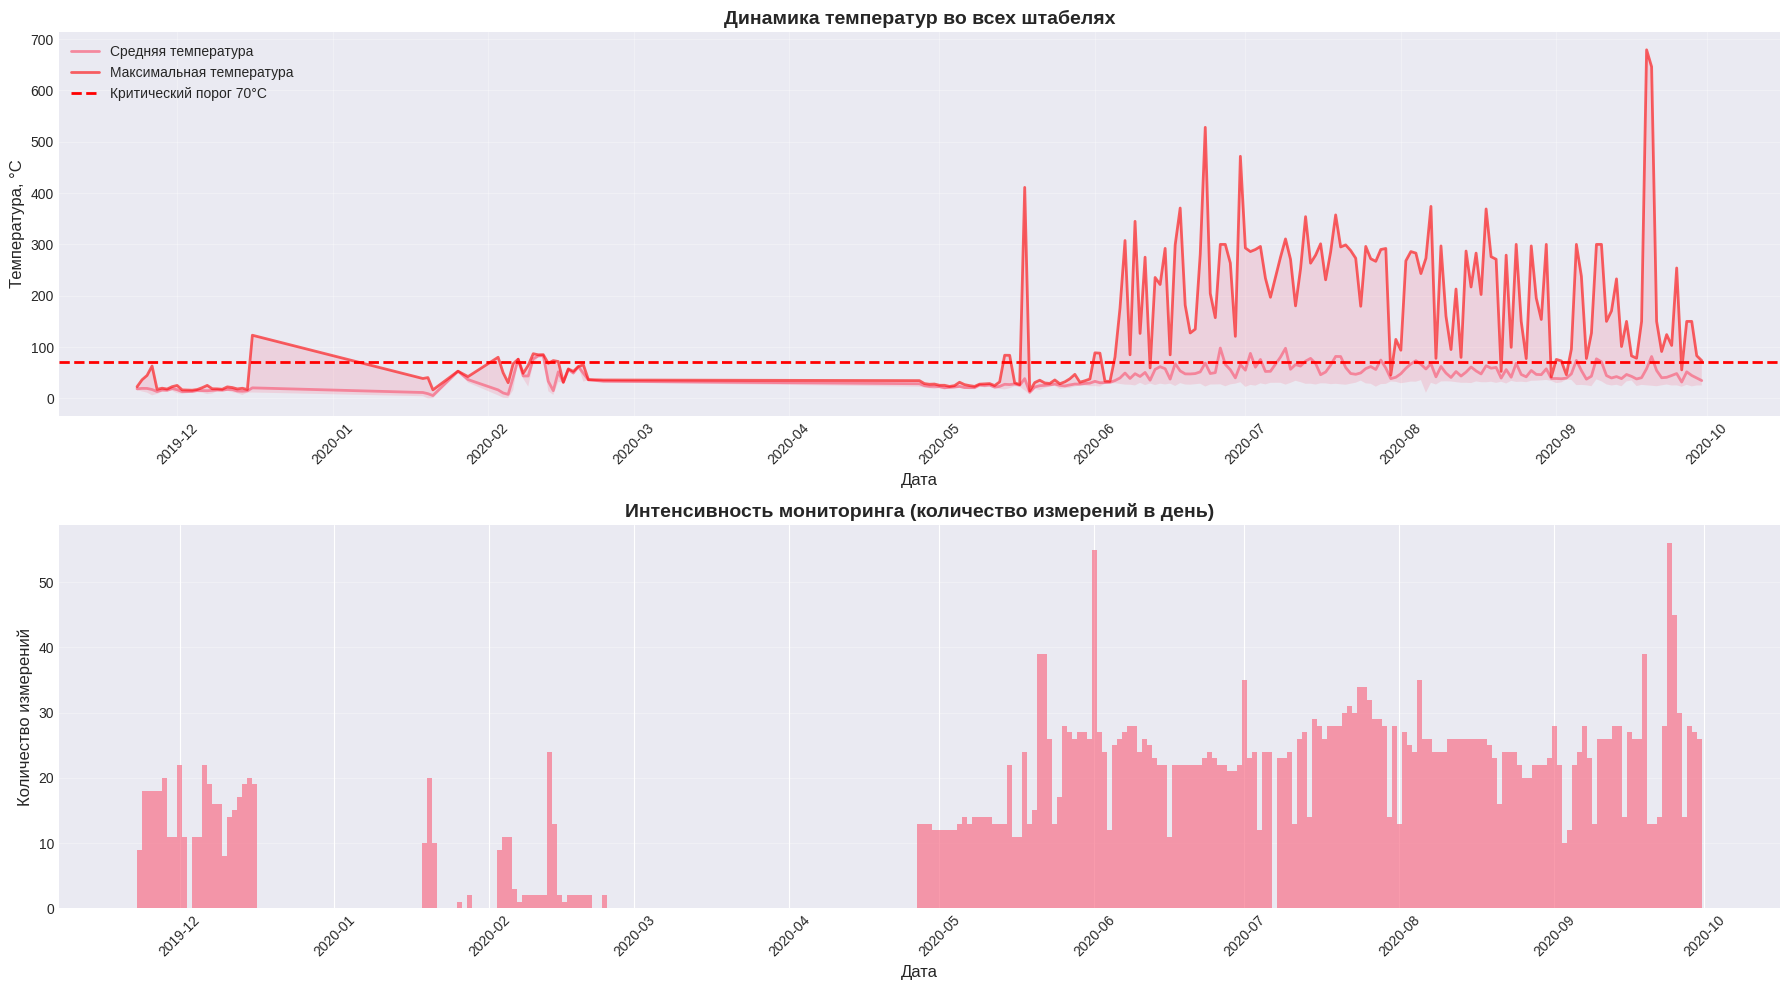


ИНТЕРПРЕТАЦИЯ:
- Средняя температура показывает общий тренд процесса окисления
- Максимальные пики указывают на потенциальные точки возгорания
- Критический порог 70°C - граница повышенного риска самовозгорания


In [ ]:
# Агрегируем температуры по дням для общего тренда
daily_temp = temperature_df.groupby('Дата акта')['Максимальная температура'].agg(['mean', 'max', 'min', 'count']).reset_index()

fig, axes = plt.subplots(2, 1, figsize=(18, 10))

# 1. Общий тренд температур
axes[0].plot(daily_temp['Дата акта'], daily_temp['mean'], label='Средняя температура', linewidth=2, alpha=0.8)
axes[0].plot(daily_temp['Дата акта'], daily_temp['max'], label='Максимальная температура', linewidth=2, alpha=0.6, color='red')
axes[0].fill_between(daily_temp['Дата акта'], daily_temp['min'], daily_temp['max'], alpha=0.2)
axes[0].axhline(y=70, color='red', linestyle='--', linewidth=2, label='Критический порог 70°C')
axes[0].set_xlabel('Дата', fontsize=12)
axes[0].set_ylabel('Температура, °C', fontsize=12)
axes[0].set_title('Динамика температур во всех штабелях', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# 2. Количество измерений по дням
axes[1].bar(daily_temp['Дата акта'], daily_temp['count'], alpha=0.7, width=1)
axes[1].set_xlabel('Дата', fontsize=12)
axes[1].set_ylabel('Количество измерений', fontsize=12)
axes[1].set_title('Интенсивность мониторинга (количество измерений в день)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\nИНТЕРПРЕТАЦИЯ:")
print("- Средняя температура показывает общий тренд процесса окисления")
print("- Максимальные пики указывают на потенциальные точки возгорания")
print("- Критический порог 70°C - граница повышенного риска самовозгорания")

### 4.3 Анализ отдельных штабелей с высокими температурами

Рассмотрим несколько штабелей с наиболее высокими температурами для понимания паттернов перегрева.

ТОП-10 ШТАБЕЛЕЙ С МАКСИМАЛЬНЫМИ ТЕМПЕРАТУРАМИ:
1. Штабель 6_4: 679.0°C (измерений: 274, период: 2020-04-27 - 2020-09-29)
2. Штабель 6_1: 528.0°C (измерений: 495, период: 2020-04-27 - 2020-09-30)
3. Штабель 4_6: 411.0°C (измерений: 116, период: 2020-01-19 - 2020-06-29)
4. Штабель 4_46: 374.0°C (измерений: 176, период: 2019-11-23 - 2020-09-30)
5. Штабель 6_10: 369.0°C (измерений: 46, период: 2020-08-02 - 2020-08-25)
6. Штабель 3_41: 354.0°C (измерений: 64, период: 2020-06-29 - 2020-08-03)
7. Штабель 4_39: 310.6°C (измерений: 214, период: 2020-01-19 - 2020-08-20)
8. Штабель 3_26: 304.0°C (измерений: 82, период: 2020-05-14 - 2020-08-25)
9. Штабель 4_3: 300.0°C (измерений: 82, период: 2020-05-07 - 2020-09-30)
10. Штабель 3_33: 300.0°C (измерений: 100, период: 2020-08-11 - 2020-09-30)


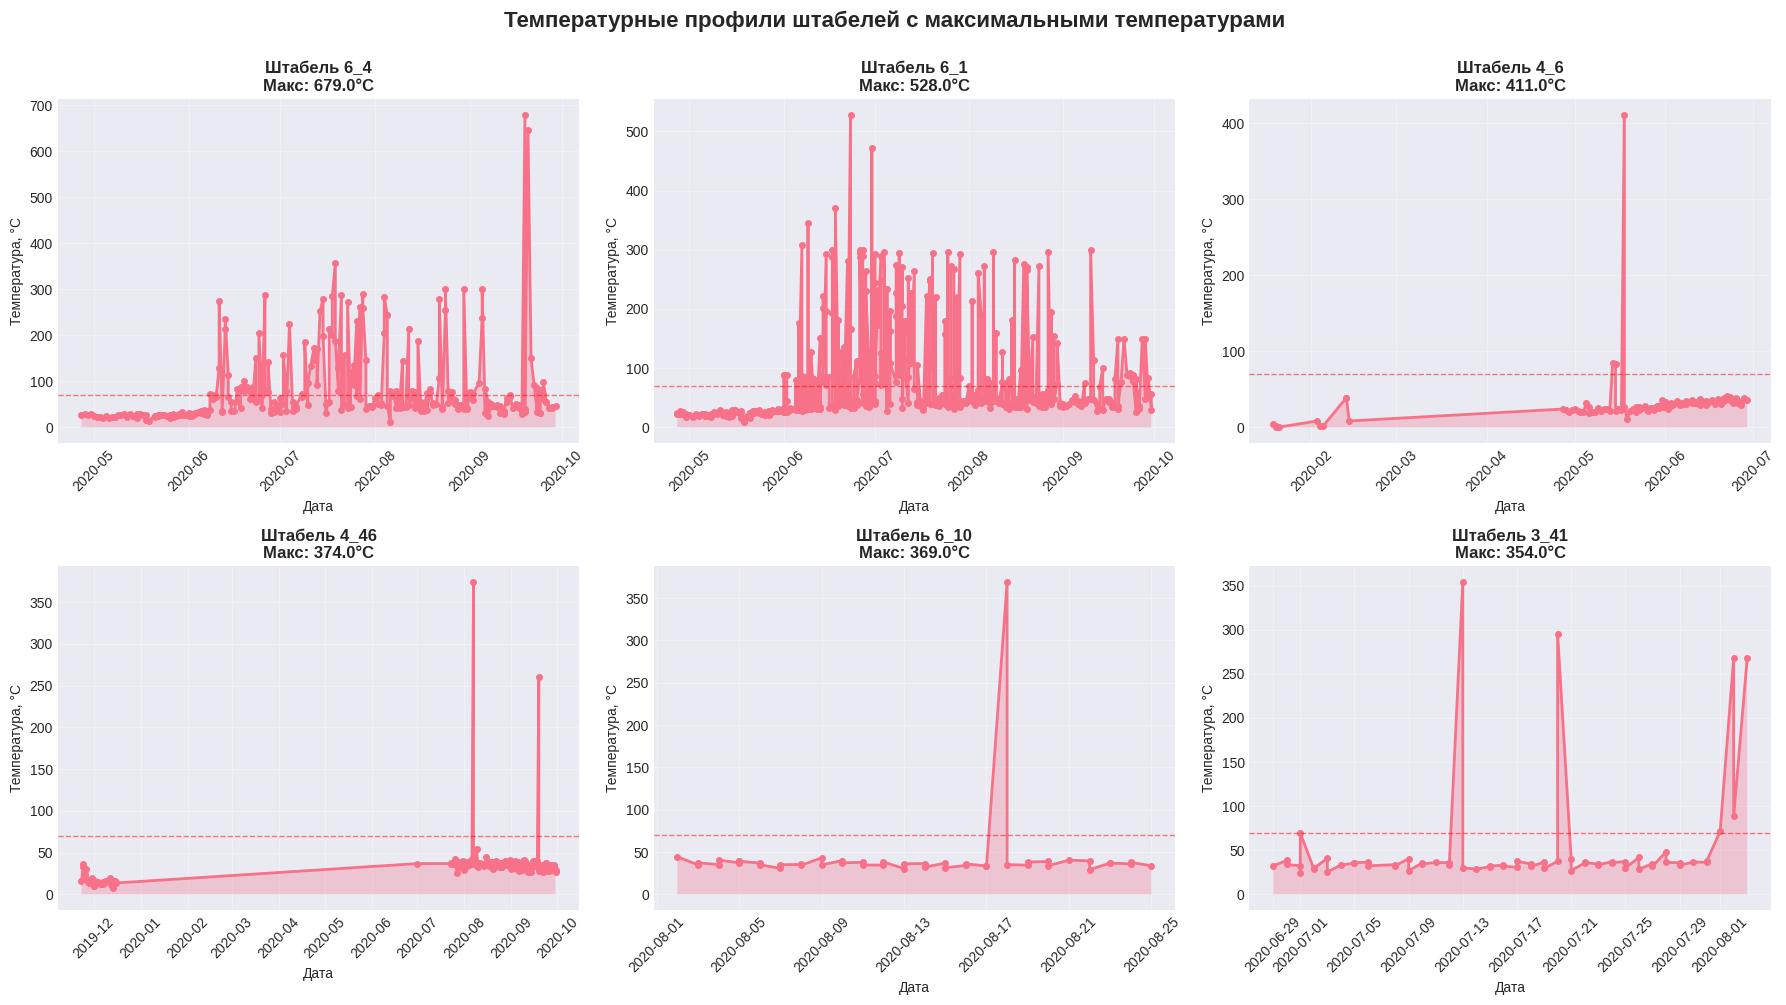

In [ ]:
# Находим штабели с максимальными температурами
top_hot_piles = temperature_df.groupby('ID_штабеля')['Максимальная температура'].max().sort_values(ascending=False).head(10)

print("ТОП-10 ШТАБЕЛЕЙ С МАКСИМАЛЬНЫМИ ТЕМПЕРАТУРАМИ:")
print("="*60)
for i, (pile_id, max_temp) in enumerate(top_hot_piles.items(), 1):
    pile_data = temperature_df[temperature_df['ID_штабеля'] == pile_id]
    measurements = len(pile_data)
    date_range = f"{pile_data['Дата акта'].min().date()} - {pile_data['Дата акта'].max().date()}"
    print(f"{i}. Штабель {pile_id}: {max_temp:.1f}°C (измерений: {measurements}, период: {date_range})")

# Визуализируем температурные профили этих штабелей
fig = plt.figure(figsize=(18, 10))

for i, pile_id in enumerate(top_hot_piles.head(6).index, 1):
    ax = plt.subplot(2, 3, i)
    pile_data = temperature_df[temperature_df['ID_штабеля'] == pile_id].sort_values('Дата акта')

    ax.plot(pile_data['Дата акта'], pile_data['Максимальная температура'],
            marker='o', linewidth=2, markersize=4)
    ax.axhline(y=70, color='red', linestyle='--', linewidth=1, alpha=0.5)
    ax.fill_between(pile_data['Дата акта'], 0, pile_data['Максимальная температура'], alpha=0.3)

    ax.set_title(f'Штабель {pile_id}\nМакс: {pile_data["Максимальная температура"].max():.1f}°C', fontweight='bold')
    ax.set_xlabel('Дата')
    ax.set_ylabel('Температура, °C')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('Температурные профили штабелей с максимальными температурами',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### 4.4 Тепловая карта температур по складам и времени

Создадим heatmap для визуализации температурных паттернов.

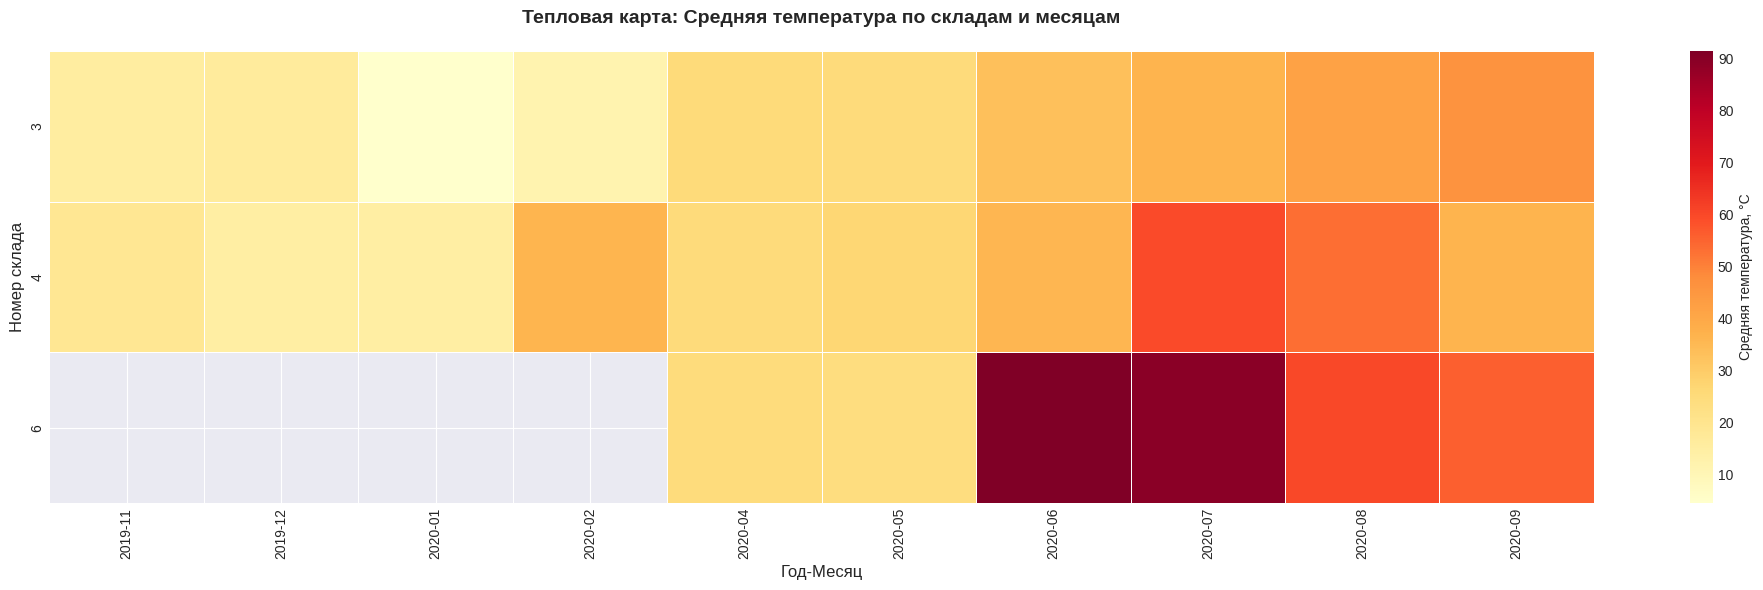


ИНТЕРПРЕТАЦИЯ ТЕПЛОВОЙ КАРТЫ:
- Более темные цвета (красные) указывают на периоды с повышенными температурами
- Светлые цвета (желтые) соответствуют нормальным температурам
- Можно выявить сезонные паттерны и проблемные склады


In [ ]:
# Создаем агрегацию по месяцам и складам
temperature_df['Год_месяц'] = temperature_df['Дата акта'].dt.to_period('M')
heatmap_data = temperature_df.pivot_table(
    values='Максимальная температура',
    index='Склад',
    columns='Год_месяц',
    aggfunc='mean'
)

# Конвертируем Period в строки для отображения
heatmap_data.columns = [str(col) for col in heatmap_data.columns]

plt.figure(figsize=(20, 6))
sns.heatmap(heatmap_data, annot=False, fmt='.1f', cmap='YlOrRd',
            cbar_kws={'label': 'Средняя температура, °C'},
            linewidths=0.5)
plt.title('Тепловая карта: Средняя температура по складам и месяцам', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Год-Месяц', fontsize=12)
plt.ylabel('Номер склада', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

print("\nИНТЕРПРЕТАЦИЯ ТЕПЛОВОЙ КАРТЫ:")
print("- Более темные цвета (красные) указывают на периоды с повышенными температурами")
print("- Светлые цвета (желтые) соответствуют нормальным температурам")
print("- Можно выявить сезонные паттерны и проблемные склады")

## 5. Анализ связи температуры с погодными условиями

### 5.1 Подготовка погодных данных для анализа корреляций

In [ ]:
# Определяем столбец с датой в погодных данных
# Ищем возможные названия столбцов
date_candidates = [col for col in weather_df.columns
                   if any(keyword in col.lower() for keyword in ['date', 'дата', 'время', 'time'])]

print(f"Найденные столбцы с датой: {date_candidates}")

if date_candidates:
    date_col = date_candidates[0]
    weather_df['Дата'] = pd.to_datetime(weather_df[date_col])

    # Объединяем температурные данные с погодой по дате
    temperature_df['Дата'] = temperature_df['Дата акта'].dt.date
    weather_df['Дата_join'] = weather_df['Дата'].dt.date

    merged_data = temperature_df.merge(
        weather_df,
        left_on='Дата',
        right_on='Дата_join',
        how='left'
    )

    print(f"\n✓ Успешно объединено {len(merged_data)} записей")
    print(f"Записей с погодными данными: {merged_data[date_col].notna().sum()}")

    # Выбираем числовые столбцы для анализа корреляций
    numeric_weather_cols = weather_df.select_dtypes(include=[np.number]).columns.tolist()
    print(f"\nЧисловые погодные параметры ({len(numeric_weather_cols)}):")
    for col in numeric_weather_cols[:10]:  # Показываем первые 10
        print(f"  - {col}")
    if len(numeric_weather_cols) > 10:
        print(f"  ... и еще {len(numeric_weather_cols) - 10}")
else:
    print("⚠ Не удалось найти столбец с датой в погодных данных")
    print("Доступные столбцы:", weather_df.columns.tolist())

Найденные столбцы с датой: ['date']

✓ Успешно объединено 98544 записей
Записей с погодными данными: 98544

Числовые погодные параметры (10):
  - t
  - p
  - humidity
  - precipitation
  - wind_dir
  - v_avg
  - v_max
  - cloudcover
  - visibility
  - weather_code


### 5.2 Корреляционный анализ

Вычислим корреляции между температурой угля и погодными параметрами.

Выбранные ключевые погодные параметры для корреляции:
  - humidity
  - wind_dir


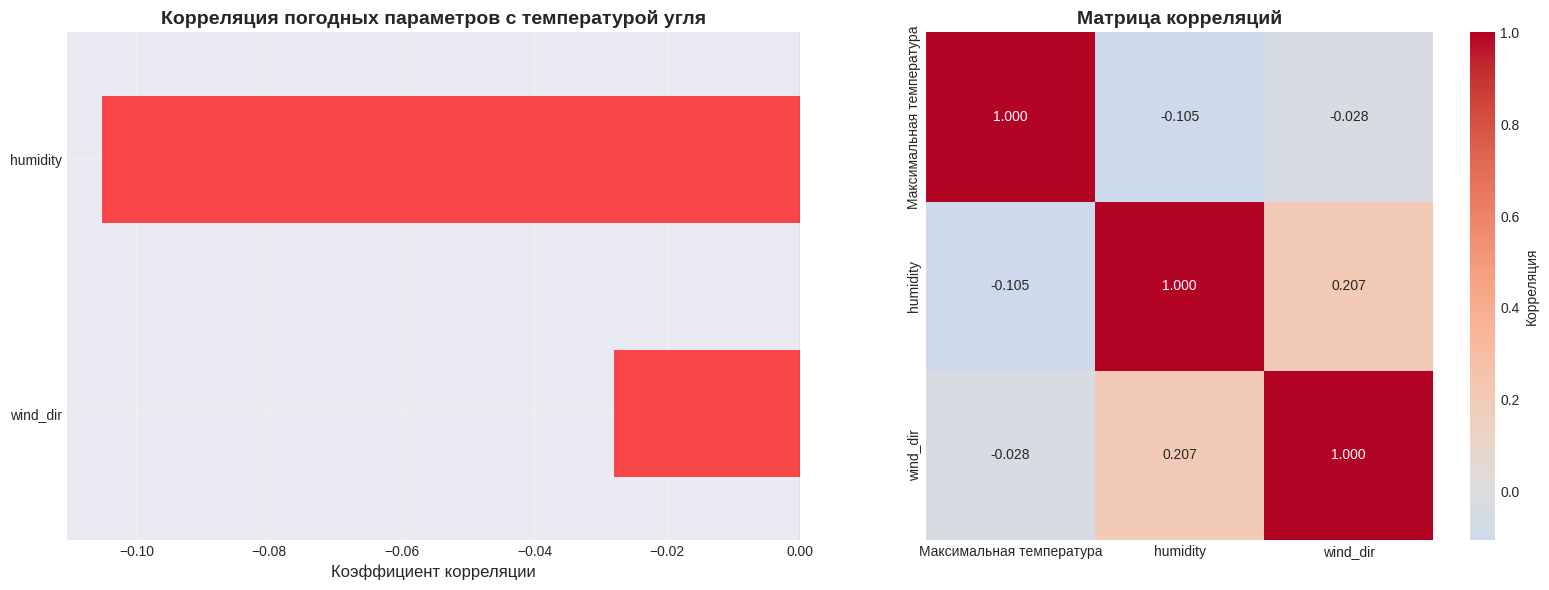


ИНТЕРПРЕТАЦИЯ КОРРЕЛЯЦИЙ

Коэффициент корреляции показывает силу и направление связи:
  • 0.7 - 1.0: Сильная положительная связь
  • 0.3 - 0.7: Умеренная положительная связь
  • -0.3 - 0.3: Слабая или отсутствующая связь
  • -0.7 - -0.3: Умеренная отрицательная связь
  • -1.0 - -0.7: Сильная отрицательная связь

Результаты корреляционного анализа:
  − wind_dir: -0.028 (слабая связь)
  − humidity: -0.105 (слабая связь)


In [ ]:
if 'merged_data' in locals() and not merged_data.empty:
    # Выбираем ключевые параметры для анализа
    # Обычно это: температура воздуха, влажность, скорость ветра, давление
    key_weather_params = []

    # Ищем релевантные столбцы по ключевым словам
    keywords = {
        'температура': ['temp', 'температура', 'т воздуха'],
        'влажность': ['humid', 'влажность', 'rh'],
        'ветер': ['wind', 'ветер', 'скорость'],
        'давление': ['press', 'давление', 'атм']
    }

    for param_name, keywords_list in keywords.items():
        for col in numeric_weather_cols:
            if any(keyword in col.lower() for keyword in keywords_list):
                key_weather_params.append(col)
                break

    print("Выбранные ключевые погодные параметры для корреляции:")
    for param in key_weather_params:
        print(f"  - {param}")

    # Вычисляем корреляции
    if key_weather_params:
        correlation_data = merged_data[['Максимальная температура'] + key_weather_params].dropna()

        if len(correlation_data) > 0:
            correlations = correlation_data.corr()['Максимальная температура'].drop('Максимальная температура').sort_values(ascending=False)

            # Визуализация корреляций
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

            # 1. Столбчатая диаграмма корреляций
            colors = ['green' if x > 0 else 'red' for x in correlations.values]
            correlations.plot(kind='barh', ax=ax1, color=colors, alpha=0.7)
            ax1.set_xlabel('Коэффициент корреляции', fontsize=12)
            ax1.set_title('Корреляция погодных параметров с температурой угля',
                         fontsize=14, fontweight='bold')
            ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
            ax1.grid(True, alpha=0.3)

            # 2. Тепловая карта всех корреляций
            corr_matrix = correlation_data.corr()
            sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm',
                       center=0, square=True, ax=ax2, cbar_kws={'label': 'Корреляция'})
            ax2.set_title('Матрица корреляций', fontsize=14, fontweight='bold')

            plt.tight_layout()
            plt.show()

            # Интерпретация результатов
            print("\n" + "="*60)
            print("ИНТЕРПРЕТАЦИЯ КОРРЕЛЯЦИЙ")
            print("="*60)
            print("\nКоэффициент корреляции показывает силу и направление связи:")
            print("  • 0.7 - 1.0: Сильная положительная связь")
            print("  • 0.3 - 0.7: Умеренная положительная связь")
            print("  • -0.3 - 0.3: Слабая или отсутствующая связь")
            print("  • -0.7 - -0.3: Умеренная отрицательная связь")
            print("  • -1.0 - -0.7: Сильная отрицательная связь")

            print("\nРезультаты корреляционного анализа:")
            for param, corr_value in correlations.items():
                if abs(corr_value) > 0.3:
                    strength = "сильная" if abs(corr_value) > 0.7 else "умеренная"
                    direction = "положительная" if corr_value > 0 else "отрицательная"
                    print(f"  ✓ {param}: {corr_value:.3f} ({strength} {direction} связь)")
                else:
                    print(f"  − {param}: {corr_value:.3f} (слабая связь)")
        else:
            print("⚠ Недостаточно данных для расчета корреляций после объединения")
    else:
        print("⚠ Не удалось идентифицировать ключевые погодные параметры")
else:
    print("⚠ Данные не были успешно объединены, пропускаем корреляционный анализ")

## 6. КРИТИЧЕСКИЙ АНАЛИЗ: Горизонт прогнозирования

### 6.1 Анализ динамики роста температуры перед возгоранием

Это **ключевой вопрос** для построения системы прогнозирования: **за сколько дней до возгорания начинается рост температуры?**

Требование задачи: горизонт прогнозирования должен быть **не менее 3 дней**.

АНАЛИЗ ГОРИЗОНТА ПРОГНОЗИРОВАНИЯ

✓ Проанализировано 486 инцидентов
✓ Получено 1525 записей для анализа горизонта

----------------------------------------------------------------------
СТАТИСТИКА ПО РАЗЛИЧНЫМ ГОРИЗОНТАМ ПРОГНОЗИРОВАНИЯ:
----------------------------------------------------------------------

📊 Горизонт 3 дней:
   • Среднее изменение температуры: -1.8°C
   • Средняя скорость роста: -0.42°C/измерение
   • Случаев с ростом температуры: 141/305 (46.2%)
   • Случаев со значительным ростом (>5°C): 119/305 (39.0%)
   ⚠ ОГРАНИЧЕННО ПОДХОДИТ (39.0% значимых изменений)

📊 Горизонт 5 дней:
   • Среднее изменение температуры: +13.8°C
   • Средняя скорость роста: +1.58°C/измерение
   • Случаев с ростом температуры: 177/305 (58.0%)
   • Случаев со значительным ростом (>5°C): 158/305 (51.8%)
   ✓ ПОДХОДИТ для прогнозирования (≥3 дня, 51.8% значимых изменений)

📊 Горизонт 7 дней:
   • Среднее изменение температуры: +15.2°C
   • Средняя скорость роста: +1.12°C/измерение
   • Случаев с 

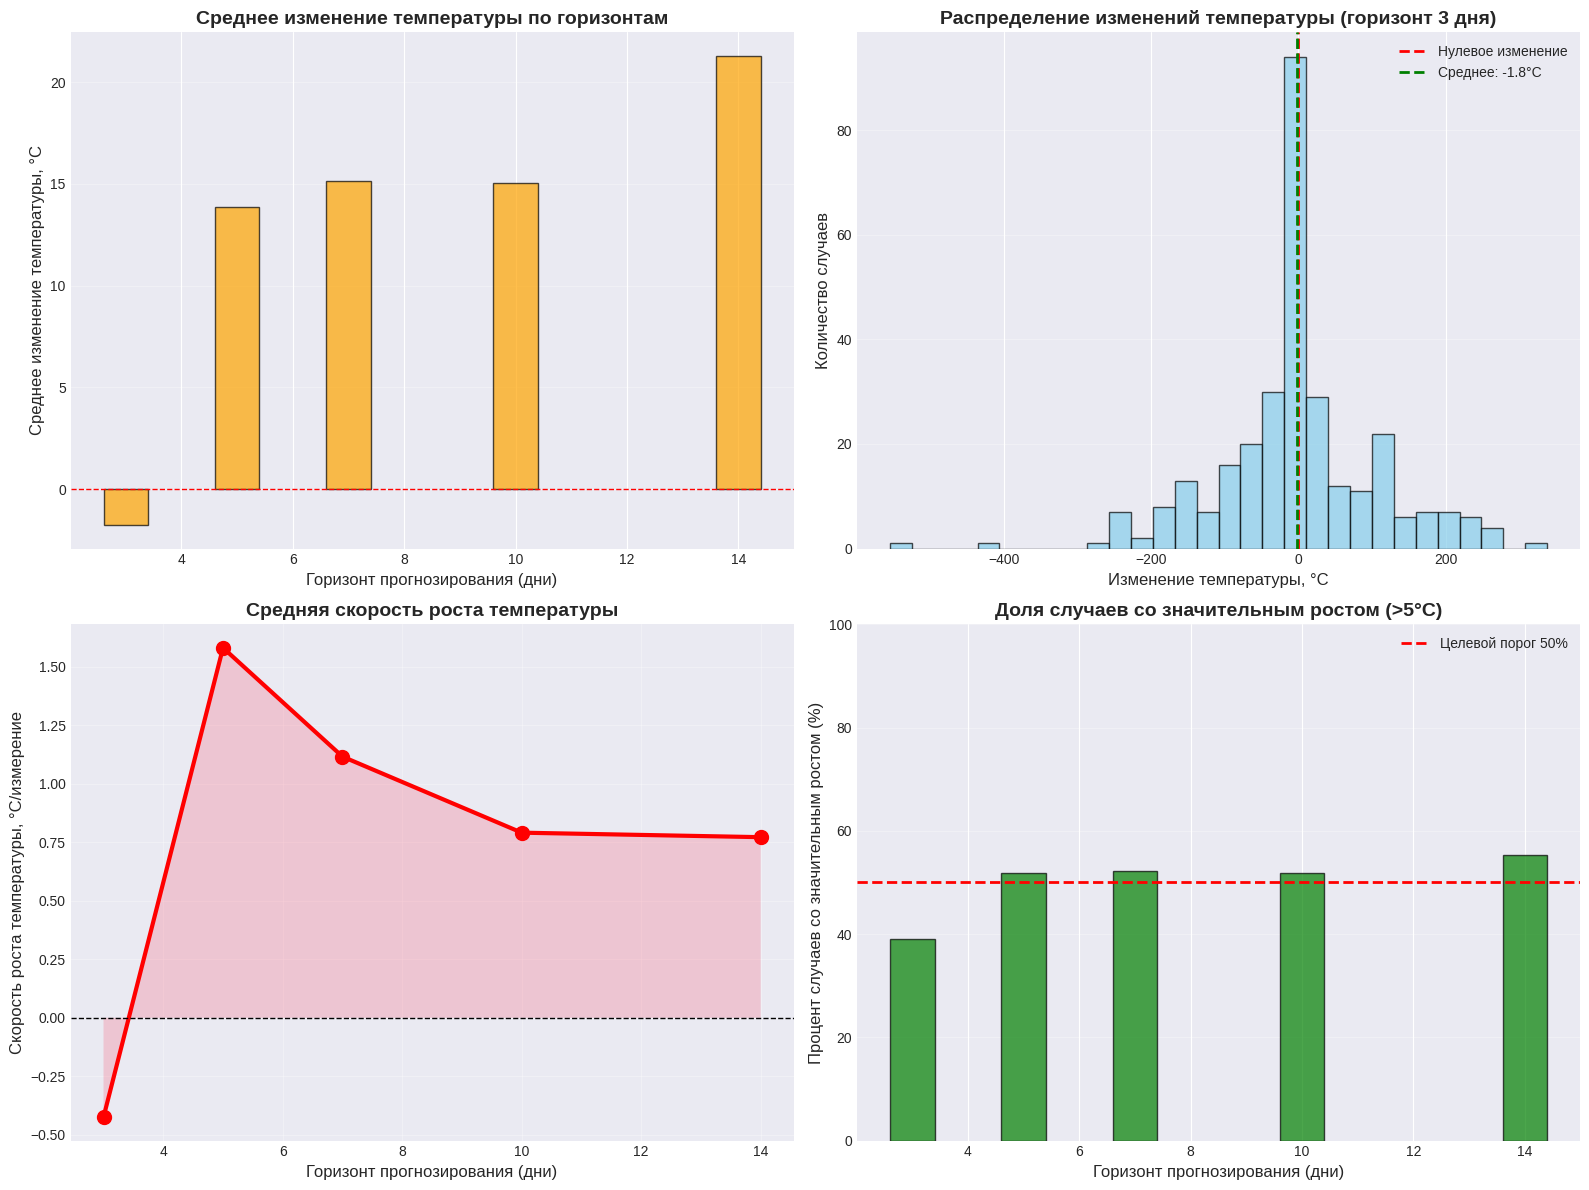

In [ ]:
print("=" * 70)
print("АНАЛИЗ ГОРИЗОНТА ПРОГНОЗИРОВАНИЯ")
print("=" * 70)

# Для каждого инцидента находим температурные данные за предшествующие дни
forecast_horizon_analysis = []

for idx, fire_row in fires_df.iterrows():
    pile_id = fire_row['ID_штабеля']
    fire_date = fire_row['Дата составления']

    # Получаем температурные данные этого штабеля до инцидента
    pile_temps = temperature_df[
        (temperature_df['ID_штабеля'] == pile_id) &
        (temperature_df['Дата акта'] < fire_date)
    ].sort_values('Дата акта')

    if len(pile_temps) > 0:
        # Находим максимальную температуру перед инцидентом
        max_temp_before = pile_temps['Максимальная температура'].max()
        last_measurement = pile_temps.iloc[-1]
        days_before = (fire_date - last_measurement['Дата акта']).days

        # Анализируем рост температуры в последние N дней
        for lookback in [3, 5, 7, 10, 14]:
            lookback_date = fire_date - pd.Timedelta(days=lookback)
            temps_in_period = pile_temps[pile_temps['Дата акта'] >= lookback_date]

            if len(temps_in_period) >= 2:
                temp_start = temps_in_period.iloc[0]['Максимальная температура']
                temp_end = temps_in_period.iloc[-1]['Максимальная температура']
                temp_change = temp_end - temp_start
                temp_growth_rate = temp_change / len(temps_in_period)

                forecast_horizon_analysis.append({
                    'ID_штабеля': pile_id,
                    'Дата_возгорания': fire_date,
                    'Горизонт_дней': lookback,
                    'Изменение_температуры': temp_change,
                    'Скорость_роста': temp_growth_rate,
                    'Температура_начало': temp_start,
                    'Температура_конец': temp_end,
                    'Количество_измерений': len(temps_in_period)
                })

horizon_df = pd.DataFrame(forecast_horizon_analysis)

if len(horizon_df) > 0:
    print(f"\n✓ Проанализировано {len(fires_df)} инцидентов")
    print(f"✓ Получено {len(horizon_df)} записей для анализа горизонта")

    # Анализируем каждый горизонт
    print("\n" + "-"*70)
    print("СТАТИСТИКА ПО РАЗЛИЧНЫМ ГОРИЗОНТАМ ПРОГНОЗИРОВАНИЯ:")
    print("-"*70)

    for horizon in [3, 5, 7, 10, 14]:
        horizon_data = horizon_df[horizon_df['Горизонт_дней'] == horizon]

        if len(horizon_data) > 0:
            avg_change = horizon_data['Изменение_температуры'].mean()
            avg_rate = horizon_data['Скорость_роста'].mean()
            positive_changes = len(horizon_data[horizon_data['Изменение_температуры'] > 0])
            pct_positive = (positive_changes / len(horizon_data)) * 100

            # Определяем, достаточен ли горизонт
            significant_changes = len(horizon_data[horizon_data['Изменение_температуры'] > 5])
            pct_significant = (significant_changes / len(horizon_data)) * 100

            print(f"\n📊 Горизонт {horizon} дней:")
            print(f"   • Среднее изменение температуры: {avg_change:+.1f}°C")
            print(f"   • Средняя скорость роста: {avg_rate:+.2f}°C/измерение")
            print(f"   • Случаев с ростом температуры: {positive_changes}/{len(horizon_data)} ({pct_positive:.1f}%)")
            print(f"   • Случаев со значительным ростом (>5°C): {significant_changes}/{len(horizon_data)} ({pct_significant:.1f}%)")

            # Оценка применимости горизонта
            if horizon >= 3 and pct_significant >= 50:
                print(f"   ✓ ПОДХОДИТ для прогнозирования (≥3 дня, {pct_significant:.1f}% значимых изменений)")
            elif horizon >= 3:
                print(f"   ⚠ ОГРАНИЧЕННО ПОДХОДИТ ({pct_significant:.1f}% значимых изменений)")
            else:
                print(f"   ✗ НЕ ПОДХОДИТ (горизонт менее 3 дней)")

    # Визуализация
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Среднее изменение температуры по горизонтам
    avg_by_horizon = horizon_df.groupby('Горизонт_дней')['Изменение_температуры'].mean()
    axes[0, 0].bar(avg_by_horizon.index, avg_by_horizon.values, color='orange', alpha=0.7, edgecolor='black')
    axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=1)
    axes[0, 0].set_xlabel('Горизонт прогнозирования (дни)', fontsize=12)
    axes[0, 0].set_ylabel('Среднее изменение температуры, °C', fontsize=12)
    axes[0, 0].set_title('Среднее изменение температуры по горизонтам', fontsize=14, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3, axis='y')

    # 2. Распределение изменений для 3-дневного горизонта
    horizon_3d = horizon_df[horizon_df['Горизонт_дней'] == 3]['Изменение_температуры']
    axes[0, 1].hist(horizon_3d, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Нулевое изменение')
    axes[0, 1].axvline(x=horizon_3d.mean(), color='green', linestyle='--', linewidth=2,
                       label=f'Среднее: {horizon_3d.mean():.1f}°C')
    axes[0, 1].set_xlabel('Изменение температуры, °C', fontsize=12)
    axes[0, 1].set_ylabel('Количество случаев', fontsize=12)
    axes[0, 1].set_title('Распределение изменений температуры (горизонт 3 дня)', fontsize=14, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3, axis='y')

    # 3. Скорость роста температуры
    avg_rate_by_horizon = horizon_df.groupby('Горизонт_дней')['Скорость_роста'].mean()
    axes[1, 0].plot(avg_rate_by_horizon.index, avg_rate_by_horizon.values,
                    marker='o', linewidth=3, markersize=10, color='red')
    axes[1, 0].axhline(y=0, color='black', linestyle='--', linewidth=1)
    axes[1, 0].fill_between(avg_rate_by_horizon.index, 0, avg_rate_by_horizon.values, alpha=0.3)
    axes[1, 0].set_xlabel('Горизонт прогнозирования (дни)', fontsize=12)
    axes[1, 0].set_ylabel('Скорость роста температуры, °C/измерение', fontsize=12)
    axes[1, 0].set_title('Средняя скорость роста температуры', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Процент случаев со значительным ростом
    significant_pct = {}
    for horizon in [3, 5, 7, 10, 14]:
        horizon_data = horizon_df[horizon_df['Горизонт_дней'] == horizon]
        if len(horizon_data) > 0:
            significant_pct[horizon] = (len(horizon_data[horizon_data['Изменение_температуры'] > 5]) /
                                       len(horizon_data)) * 100

    axes[1, 1].bar(significant_pct.keys(), significant_pct.values(),
                   color='green', alpha=0.7, edgecolor='black')
    axes[1, 1].axhline(y=50, color='red', linestyle='--', linewidth=2, label='Целевой порог 50%')
    axes[1, 1].set_xlabel('Горизонт прогнозирования (дни)', fontsize=12)
    axes[1, 1].set_ylabel('Процент случаев со значительным ростом (%)', fontsize=12)
    axes[1, 1].set_title('Доля случаев со значительным ростом (>5°C)', fontsize=14, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    axes[1, 1].set_ylim([0, 100])

    plt.tight_layout()
    plt.show()

else:
    print("⚠ Недостаточно данных для анализа горизонта прогнозирования")
    print("   Возможные причины:")
    print("   - Нет температурных измерений для штабелей с инцидентами")
    print("   - Несоответствие ID штабелей между датасетами")

### 6.2 Детальный анализ паттернов роста температуры

Рассмотрим конкретные примеры изменения температуры перед возгоранием.

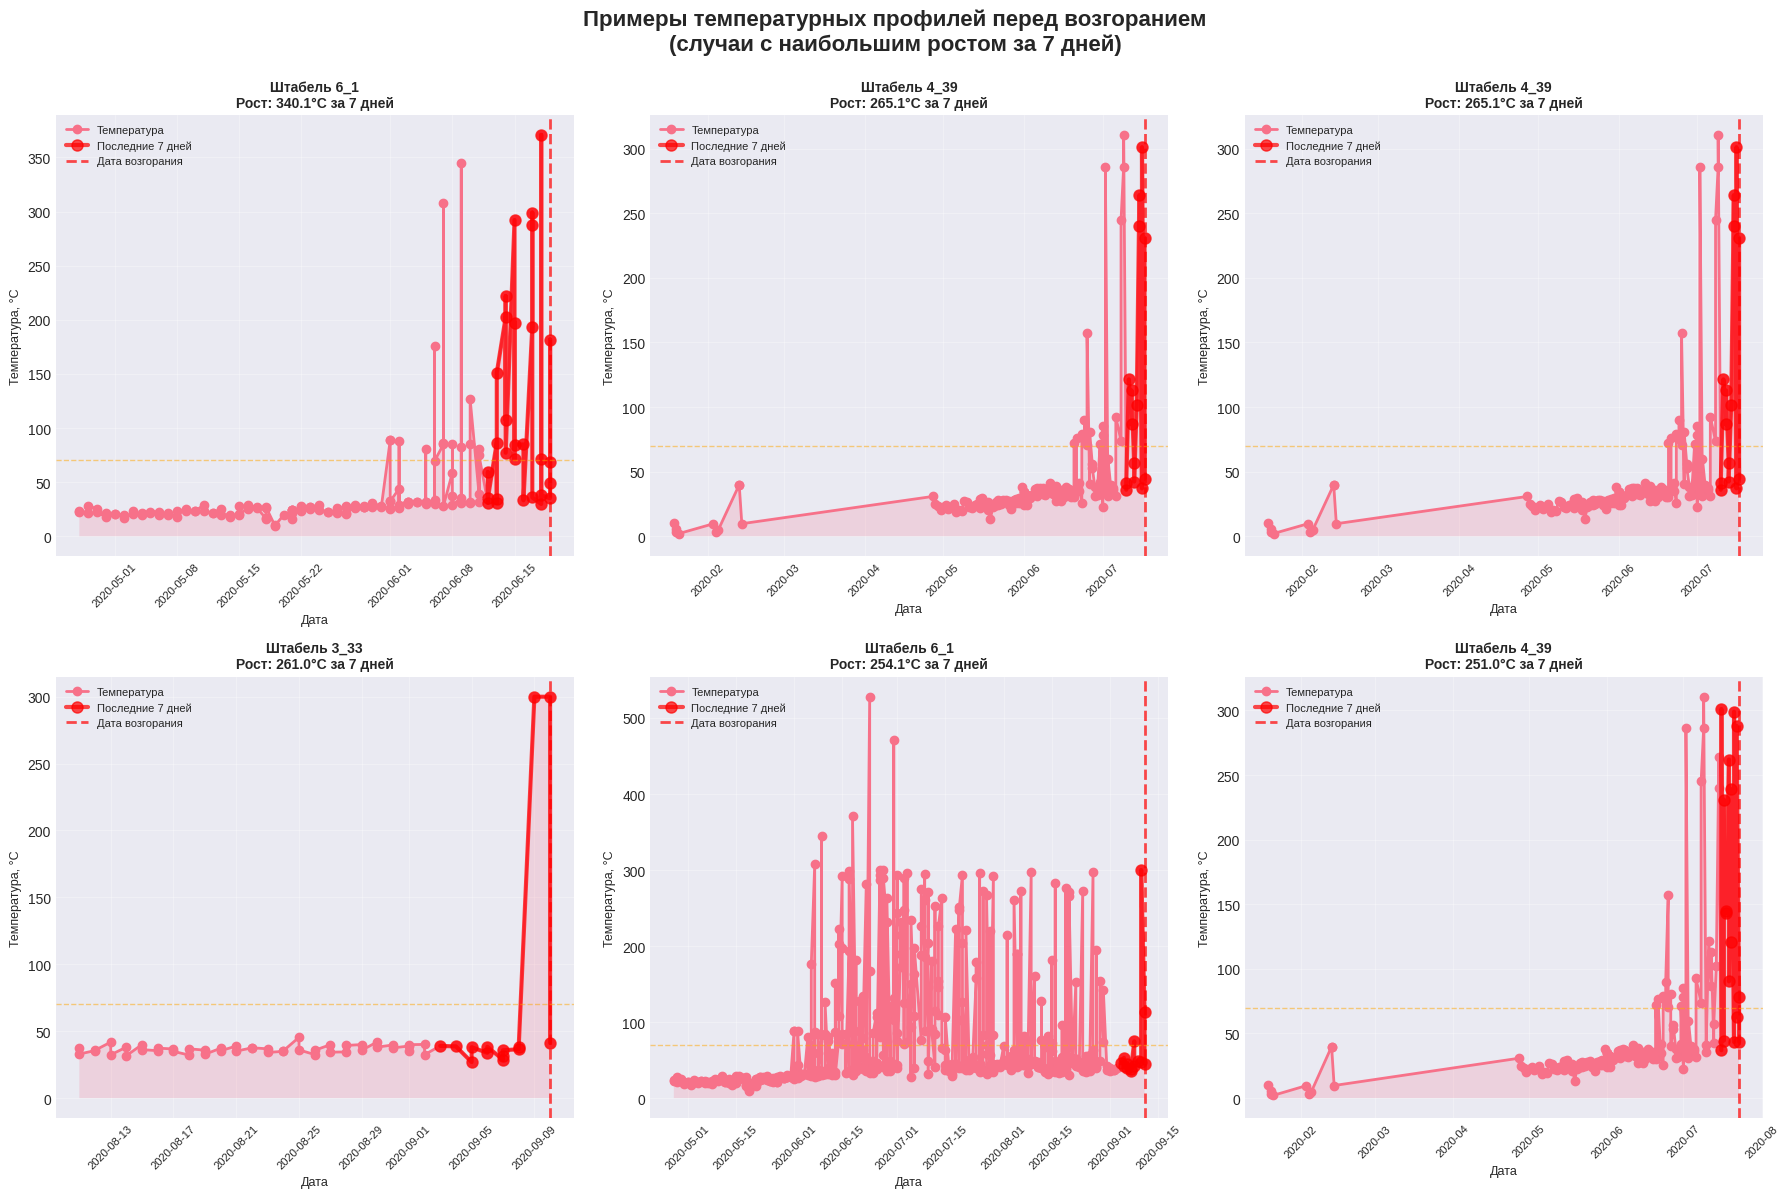

In [ ]:
if len(horizon_df) > 0:
    # Выбираем несколько случаев с наиболее выраженным ростом температуры
    top_growth_cases = horizon_df[horizon_df['Горизонт_дней'] == 7].nlargest(6, 'Изменение_температуры')

    if len(top_growth_cases) > 0:
        fig = plt.figure(figsize=(18, 12))

        for i, (idx, case) in enumerate(top_growth_cases.iterrows(), 1):
            pile_id = case['ID_штабеля']
            fire_date = case['Дата_возгорания']

            # Получаем полную историю температур этого штабеля
            pile_history = temperature_df[
                (temperature_df['ID_штабеля'] == pile_id) &
                (temperature_df['Дата акта'] <= fire_date)
            ].sort_values('Дата акта')

            if len(pile_history) > 0:
                ax = plt.subplot(2, 3, i)

                # Рисуем полную историю
                ax.plot(pile_history['Дата акта'], pile_history['Максимальная температура'],
                       marker='o', linewidth=2, markersize=6, label='Температура')

                # Выделяем последние 7 дней перед возгоранием
                last_7d = pile_history[pile_history['Дата акта'] >= fire_date - pd.Timedelta(days=7)]
                if len(last_7d) > 0:
                    ax.plot(last_7d['Дата акта'], last_7d['Максимальная температура'],
                           marker='o', linewidth=3, markersize=8, color='red',
                           label='Последние 7 дней', alpha=0.7)

                # Отмечаем дату возгорания
                ax.axvline(x=fire_date, color='red', linestyle='--', linewidth=2,
                          label='Дата возгорания', alpha=0.7)
                ax.axhline(y=70, color='orange', linestyle='--', linewidth=1, alpha=0.5)

                ax.fill_between(pile_history['Дата акта'],
                               pile_history['Максимальная температура'],
                               alpha=0.2)

                ax.set_title(f"Штабель {pile_id}\nРост: {case['Изменение_температуры']:.1f}°C за 7 дней",
                           fontweight='bold', fontsize=10)
                ax.set_xlabel('Дата', fontsize=9)
                ax.set_ylabel('Температура, °C', fontsize=9)
                ax.legend(fontsize=8, loc='upper left')
                ax.grid(True, alpha=0.3)
                ax.tick_params(axis='x', rotation=45, labelsize=8)

        plt.suptitle('Примеры температурных профилей перед возгоранием\n(случаи с наибольшим ростом за 7 дней)',
                    fontsize=16, fontweight='bold', y=0.995)
        plt.tight_layout()
        plt.show()
    else:
        print("Недостаточно данных для визуализации конкретных случаев")
else:
    print("Анализ паттернов роста невозможен без данных о горизонте прогнозирования")

## 7. Ключевые выводы и рекомендации

### 7.1 Основные находки EDA

In [ ]:
print("\n" + "="*80)
print("КЛЮЧЕВЫЕ ВЫВОДЫ РАЗВЕДОЧНОГО АНАЛИЗА ДАННЫХ")
print("="*80)

print("\n📊 1. КАЧЕСТВО И ПОЛНОТА ДАННЫХ:")
print("   ✓ Температурные данные:")
print(f"     - Всего измерений: {len(temperature_df)}")
print(f"     - Уникальных штабелей: {temperature_df['ID_штабеля'].nunique()}")
print(f"     - Период наблюдений: {(temperature_df['Дата акта'].max() - temperature_df['Дата акта'].min()).days} дней")
print(f"     - Диапазон температур: {temperature_df['Максимальная температура'].min():.1f}°C - {temperature_df['Максимальная температура'].max():.1f}°C")

print("\n   ✓ Данные о возгораниях:")
print(f"     - Всего инцидентов: {len(fires_df)}")
print(f"     - Среднее время до возгорания: {fires_df['Дней_до_инцидента'].mean():.1f} дней")

print("\n   ✓ Погодные данные:")
print(f"     - Всего записей: {len(weather_df)}")
print(f"     - Период: {len(weather_years)} лет ({min(weather_years)}-{max(weather_years)})")

if len(horizon_df) > 0:
    print("\n🎯 2. ГОРИЗОНТ ПРОГНОЗИРОВАНИЯ:")

    for horizon in [3, 5, 7]:
        horizon_data = horizon_df[horizon_df['Горизонт_дней'] == horizon]
        if len(horizon_data) > 0:
            avg_change = horizon_data['Изменение_температуры'].mean()
            positive_pct = (len(horizon_data[horizon_data['Изменение_температуры'] > 0]) / len(horizon_data)) * 100
            significant_pct = (len(horizon_data[horizon_data['Изменение_температуры'] > 5]) / len(horizon_data)) * 100

            print(f"\n   Горизонт {horizon} дней:")
            print(f"     - Среднее изменение температуры: {avg_change:+.1f}°C")
            print(f"     - Рост температуры наблюдается в {positive_pct:.1f}% случаев")
            print(f"     - Значительный рост (>5°C) в {significant_pct:.1f}% случаев")

            if horizon == 3:
                if significant_pct >= 50:
                    confidence = "ВЫСОКАЯ"
                    recommendation = "✓ РЕКОМЕНДУЕТСЯ для прогнозирования"
                elif significant_pct >= 30:
                    confidence = "СРЕДНЯЯ"
                    recommendation = "⚠ ВОЗМОЖНО использование с дополнительными признаками"
                else:
                    confidence = "НИЗКАЯ"
                    recommendation = "✗ ТРЕБУЕТСЯ обогащение данных или пересмотр подхода"

                print(f"     - Уверенность прогноза: {confidence}")
                print(f"     - {recommendation}")

print("\n🔥 3. КРИТИЧЕСКИЕ ТЕМПЕРАТУРЫ:")
critical_70 = len(temperature_df[temperature_df['Максимальная температура'] > 70])
critical_80 = len(temperature_df[temperature_df['Максимальная температура'] > 80])
critical_90 = len(temperature_df[temperature_df['Максимальная температура'] > 90])
print(f"   - Измерений с T > 70°C: {critical_70} ({critical_70/len(temperature_df)*100:.1f}%)")
print(f"   - Измерений с T > 80°C: {critical_80} ({critical_80/len(temperature_df)*100:.1f}%)")
print(f"   - Измерений с T > 90°C: {critical_90} ({critical_90/len(temperature_df)*100:.1f}%)")

print("\n📈 4. ПАТТЕРНЫ И ТРЕНДЫ:")
print(f"   - Средняя температура в штабелях: {temperature_df['Максимальная температура'].mean():.1f}°C")
print(f"   - Стандартное отклонение: {temperature_df['Максимальная температура'].std():.1f}°C")
print(f"   - Коэффициент вариации: {(temperature_df['Максимальная температура'].std() / temperature_df['Максимальная температура'].mean()) * 100:.1f}%")

if 'merged_data' in locals() and not merged_data.empty:
    print("\n   ✓ Корреляции с погодой доступны для анализа")
else:
    print("\n   ⚠ Корреляции с погодой требуют дополнительной обработки данных")

print("\n" + "="*80)


КЛЮЧЕВЫЕ ВЫВОДЫ РАЗВЕДОЧНОГО АНАЛИЗА ДАННЫХ

📊 1. КАЧЕСТВО И ПОЛНОТА ДАННЫХ:
   ✓ Температурные данные:
     - Всего измерений: 4106
     - Уникальных штабелей: 69
     - Период наблюдений: 312 дней
     - Диапазон температур: 0.0°C - 679.0°C

   ✓ Данные о возгораниях:
     - Всего инцидентов: 486
     - Среднее время до возгорания: 94.9 дней

   ✓ Погодные данные:
     - Всего записей: 61344
     - Период: 7 лет (2015-2021)

🎯 2. ГОРИЗОНТ ПРОГНОЗИРОВАНИЯ:

   Горизонт 3 дней:
     - Среднее изменение температуры: -1.8°C
     - Рост температуры наблюдается в 46.2% случаев
     - Значительный рост (>5°C) в 39.0% случаев
     - Уверенность прогноза: СРЕДНЯЯ
     - ⚠ ВОЗМОЖНО использование с дополнительными признаками

   Горизонт 5 дней:
     - Среднее изменение температуры: +13.8°C
     - Рост температуры наблюдается в 58.0% случаев
     - Значительный рост (>5°C) в 51.8% случаев

   Горизонт 7 дней:
     - Среднее изменение температуры: +15.2°C
     - Рост температуры наблюдается в 6